# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json


from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
import seaborn as sns #For Data visualization

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
from datetime import datetime
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer

### Clean portfolio data

In [3]:
def clean_offertype(portfolio=portfolio):
    '''
    INPUT:
    portfolio - (pandas dataframe), portfolio data
    
    OUTPUT:
    portfolio - (pandas dataframe), cleaned portfolio data

    
    Description:
    This function cleans the dat and provides a DatFrame with Offer ID and other data about the offer. 
    '''    
    
    # One hot encode the 'offertype' column
    offertype = pd.get_dummies(portfolio['offer_type'])
    
    # One hot encode the 'channels' columns
    mlb = MultiLabelBinarizer()
    mlb_fit = mlb.fit(portfolio['channels'])
    channels_df = pd.DataFrame(mlb_fit.transform(portfolio['channels']),columns=mlb_fit.classes_)
    
    #Drop the old 'channels' and 'offer_type' columns
    portfolio = portfolio.drop(columns=['channels', 'offer_type'])
    
    #Replace the 'offertype' and 'channels' columns
    portfolio = pd.concat([portfolio, offertype, channels_df], axis=1)
    
    #Rename 'duration' and 'id' column
    portfolio = portfolio.rename(columns={"duration": "DurationDays", "id": "OfferId"})
    
    #Reorder the columns order
    portfolio = portfolio[[ 'OfferId','difficulty','DurationDays','reward','bogo','discount',
                            'informational','email','mobile','social','web']]

    return portfolio

### Clean profile data

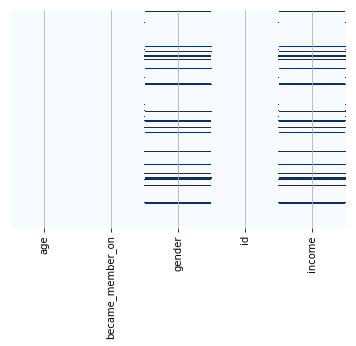

In [4]:
# Find and visualize Missing Data


sns.heatmap(profile.isnull(), yticklabels = False, cbar = False, cmap="Blues")
profile.isnull().sum(axis=0) * 100  / profile.shape[0]
profile['age'].hist(bins = 25)
# Remove customers with N/A income data
profile = profile[profile['income'].notnull()]
profile['age'].hist(bins = 25)
profile.isnull().sum(axis=0) * 100  / profile.shape[0]
profile['income'].hist(bins = 100)

In [5]:
def clean_profile(profile = profile):
    
    #Removed those with no income data
    profile = profile[profile['income'].notnull()]
    
    
    #Removed customer with unspecified Gender
    profile = profile[profile['gender'] != 'O']
    profile = profile.reset_index(drop=True)
    
    #Change datetype of bacame_member_on column
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')   
    
    profile['membership_year'] = profile['became_member_on'].apply(lambda elem: elem.year)
    
    
    return profile

In [6]:
def clean_profile_final(profile = profile):
    
    #Removed those with no income data
    profile = profile[profile['income'].notnull()]
    
    
    #Removed customer with unspecified Gender
    profile = profile[profile['gender'] != 'O']
    profile = profile.reset_index(drop=True)
    
    binarizerobj = LabelBinarizer()
    profile['gender'] = binarizerobj.fit_transform(profile['gender'])
    
    gender_integer_map = {}
    for i in binarizerobj.classes_:
        gender_integer_map[i] = binarizerobj.transform([i])[0,0]
        
        
    
    #Change datetype of bacame_member_on column
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')   
    #Encode the year values
    profile['membership_year'] = profile['became_member_on'].apply(lambda elem: elem.year)
    membership_year_df = pd.get_dummies(profile['membership_year'])
    
    
    #Group the age ranges
    labels = ['Generation Z','Millennials', 'Generation X', 'Baby Boomers', 'The Silent Generation']
    profile['age_group'] = pd.cut(profile['age'], bins=5, labels=labels)
    # Encode for Age ranges
    agerange_df = pd.get_dummies(profile['age_group'])
    
    # Appened all the encoded variables to the main dataframe
    profile = pd.concat([profile,
                         agerange_df,
                         membership_year_df], axis=1)

    # Drop depcreated columns
    profile = profile.drop(columns=['age',
                                    'age_group',
                                    'became_member_on',
                                    'membership_year'])    
    return profile
    

### Analyze transcript Dated

In [8]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [23]:
transcript['person'].nunique()
profile['id'].nunique()

14825

In [26]:
transcript['person'].count()

306534

In [25]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [21]:
profile.head(1)

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0


event     0.0
person    0.0
time      0.0
value     0.0
dtype: float64

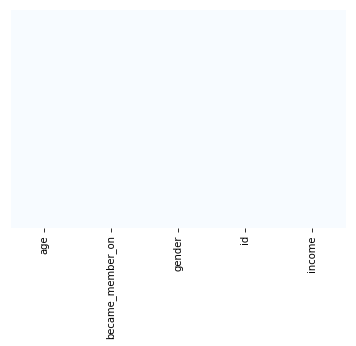